In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
import itertools
import matplotlib.style
import scipy.stats
import math
import statsmodels.api as sm
import random
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
import scipy.sparse
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV, LassoCV

/kaggle/input/uspollution/pollution_us_2000_2016.csv


# Introduction

I choose to work on the US Air Pollution data in the project datasets. This dataset includes documented Air Pollution data like CO from 2000 - 2016. I will introduce this project step by step below.

In this project, I hope to:

1. engineer dataset to use "State Code" and "Pollutant" as dependent variables to try predict " Mean AQI"
2. use multiple models tested with bootstrap to compare the performance and see if we can help make sense of air pollution

These two questions can be answered with models with shrinkage methods and non linear approaches, and could potentially benefit people by providing a data analytic view of pollution, combined with real world incidents we could take impactful actions in the future to prevent or predict air pollutions.

In [2]:
df = pd.read_csv("/kaggle/input/uspollution/pollution_us_2000_2016.csv")

# Data Cleaning

As per my EDA, I want to focus on working at a State level, so we can drop irrelevant features. 

In [3]:
df_clean = df.drop(["County Code", "Site Num", "Address", "City", "Unnamed: 0", "NO2 Units", "O3 Units", "SO2 Units", "CO Units"], axis = 1)

In [4]:
df_clean['Date Local'] = pd.to_datetime(df_clean['Date Local'],format='%Y-%m-%d')

# Data Analysis
Now we perform data analysis, we need to first engineer our dataset. The features we are interested in are: State Code (for easier readability), Pollutant Type, and AQI for that pollutant in that state. By doing engineering this way we can efficiently narrow our problem to understanding a specific pollutant in a specific state, across all states and all 4 types of pollutants. 

PS: From later on, AQI refers to the mean of AQI

First, I need to preprocess the dataset the way I want, each state has 4 rows with each row representing different pollutant.

In [5]:
pollutants = ['NO2', 'O3', 'SO2', 'CO']
aqi = ['NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']
df_processed = pd.melt(df_clean, id_vars=['State Code'], value_vars=aqi, var_name='Pollutant', value_name='AQI')

df_processed['Pollutant'] = df_processed['Pollutant'].replace({f'{p} AQI': p for p in pollutants})

df_processed['State Code'] = pd.Categorical(df_processed['State Code'])
df_processed['Pollutant'] = pd.Categorical(df_processed['Pollutant'])

mean_aqi = df_processed.groupby(['State Code', 'Pollutant']).agg({'AQI': 'mean'}).reset_index()

mean_aqi = mean_aqi.dropna()
mean_aqi.head()

,State Code,Pollutant,AQI
0,1,CO,3.850288
1,1,NO2,21.232246
2,1,O3,36.845170
3,1,SO2,7.005115
4,2,CO,6.528340


# Bootstrap with Linear Model
next, I will perform bootstrap to find the confidence intervals of all the models to be used in the following part, and interpret the results, the detailed steps will be: 
1. Prepare the data for regression by one-hot encoding, pick X to be state and pollutant to be specific in pollution type and location
2. Fit a model of interest
3. Calculate the R-squared and RMSE values per each iteration
4. Perform bootstrapping to estimate the confidence intervals for R-squared and RMSE
5. Plot the confidence intervals for both R_squared and RMSE

Bootstrapped R-squared 95% CI: (0.706, 0.849)
Bootstrapped RMSE 95% CI: (5.412, 7.556)


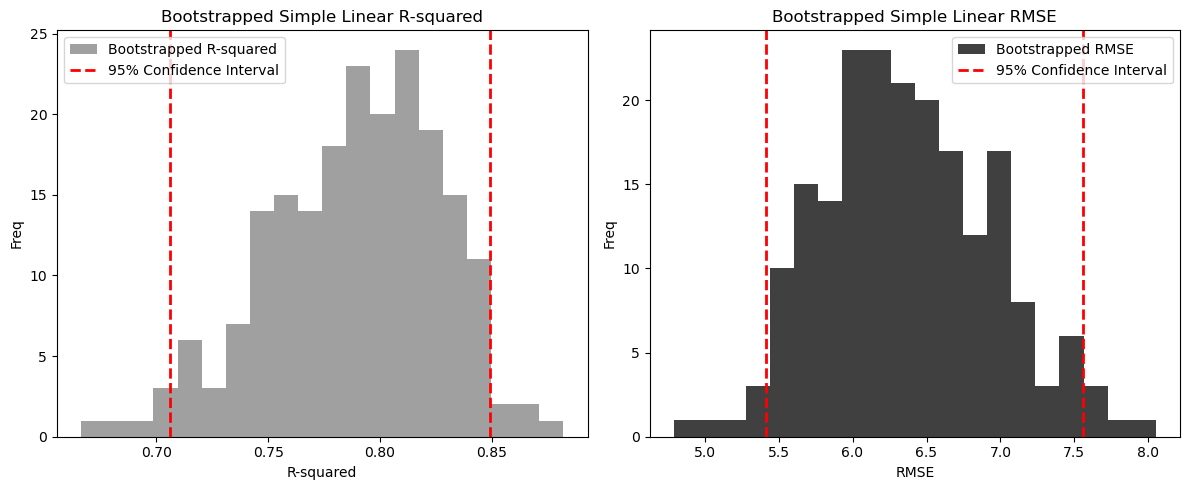

In [6]:
X = mean_aqi[['State Code', 'Pollutant']]
y = mean_aqi['AQI']

encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

n_bootstraps = 200
r2_bootstraps = []
rmse_bootstraps = []

for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_train, y_train)
    model = LinearRegression()
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    
    r2_bootstraps.append(r2_score(y_test, y_pred))
    rmse_bootstraps.append(np.sqrt(mean_squared_error(y_test, y_pred)))

r2_ci_lower = np.percentile(r2_bootstraps, 2.5)
r2_ci_upper = np.percentile(r2_bootstraps, 97.5)
rmse_ci_lower = np.percentile(rmse_bootstraps, 2.5)
rmse_ci_upper = np.percentile(rmse_bootstraps, 97.5)

print(f"Bootstrapped R-squared 95% CI: ({r2_ci_lower:.3f}, {r2_ci_upper:.3f})")
print(f"Bootstrapped RMSE 95% CI: ({rmse_ci_lower:.3f}, {rmse_ci_upper:.3f})")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(r2_bootstraps, bins=20, alpha=0.75, color='gray', label='Bootstrapped R-squared')
ax[0].axvline(r2_ci_lower, color='red', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax[0].axvline(r2_ci_upper, color='red', linestyle='dashed', linewidth=2)
ax[0].set_xlabel('R-squared')
ax[0].set_ylabel('Freq')
ax[0].set_title('Bootstrapped Simple Linear R-squared')
ax[0].legend()

ax[1].hist(rmse_bootstraps, bins=20, alpha=0.75, color='black', label='Bootstrapped RMSE')
ax[1].axvline(rmse_ci_lower, color='red', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax[1].axvline(rmse_ci_upper, color='red', linestyle='dashed', linewidth=2)
ax[1].set_xlabel('RMSE')
ax[1].set_ylabel('Freq')
ax[1].set_title('Bootstrapped Simple Linear RMSE')
ax[1].legend()

plt.tight_layout()
plt.show()

As we can see, the distribution of R_squared is centered around 0.8, with a wide spread from 0.75 to 0.85, whereas the distribution for RMSE is centered at 6.5, with a even spread from 5.5 to 7, this means the R_squared and RMSE are covering a wide range and potentially not as precise as we want since it accounts to a lot of variability.

We can see that the linear regression model does a fairly good job of explaining the variability in the AQI values, as suggested by the good R-squared value. The RMSE indicates that the model's predictions are generally accurate, but there is still some unexplained variability that are very high in terms of RMSE. The bootstrapped confidence intervals distribution here suggests that the model's performance is not perfect, but it does provide a reasonable starting point for understanding the relationship between the states + pollutant and AQI values. This means there are potential improvements we can make to the model, one direct response to this question would be to try and use the shrinkage methods, specifically Ridge and Lasso.

# Shrinkage Method: Ridge and Lasso Alpha Selection Using Cross Validation

To test shrinkage methods with bootstrap, we need to first find the best alphas for both shrinkage methods, using cross validation.

Luckily there are built-in methods that provides CV tested optimal values for the alphas of both shrikage methods.

In [7]:
X = mean_aqi[['State Code', 'Pollutant']]
y = mean_aqi['AQI']

encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)


alphas = np.logspace(-4, 4, 100)

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

print("Best alpha for Ridge Regression: {:.4f}".format(ridge_cv.alpha_))
print("Best alpha for Lasso Regression: {:.4f}".format(lasso_cv.alpha_))

Best alpha for Ridge Regression: 1.3219
Best alpha for Lasso Regression: 0.1417


Now we know the optimal alpha for Ridge Regression is 1.32 and the optimal for Lasso is 0.14, we can put them into our model. 
Next, I will use bootstrap to find the confidence interval of R_squared and RMSE of both models and compare them to simple linear model.

# Bootstrap with Shrikage Methods

Ridge Regression:
Bootstrapped R-squared 95% CI: [0.77939518 0.86461828]
Bootstrapped RMSE 95% CI: [5.03495714 6.42723314]

Lasso Regression:
Bootstrapped R-squared 95% CI: [0.82170154 0.87168869]
Bootstrapped RMSE 95% CI: [4.901726   5.77817339]


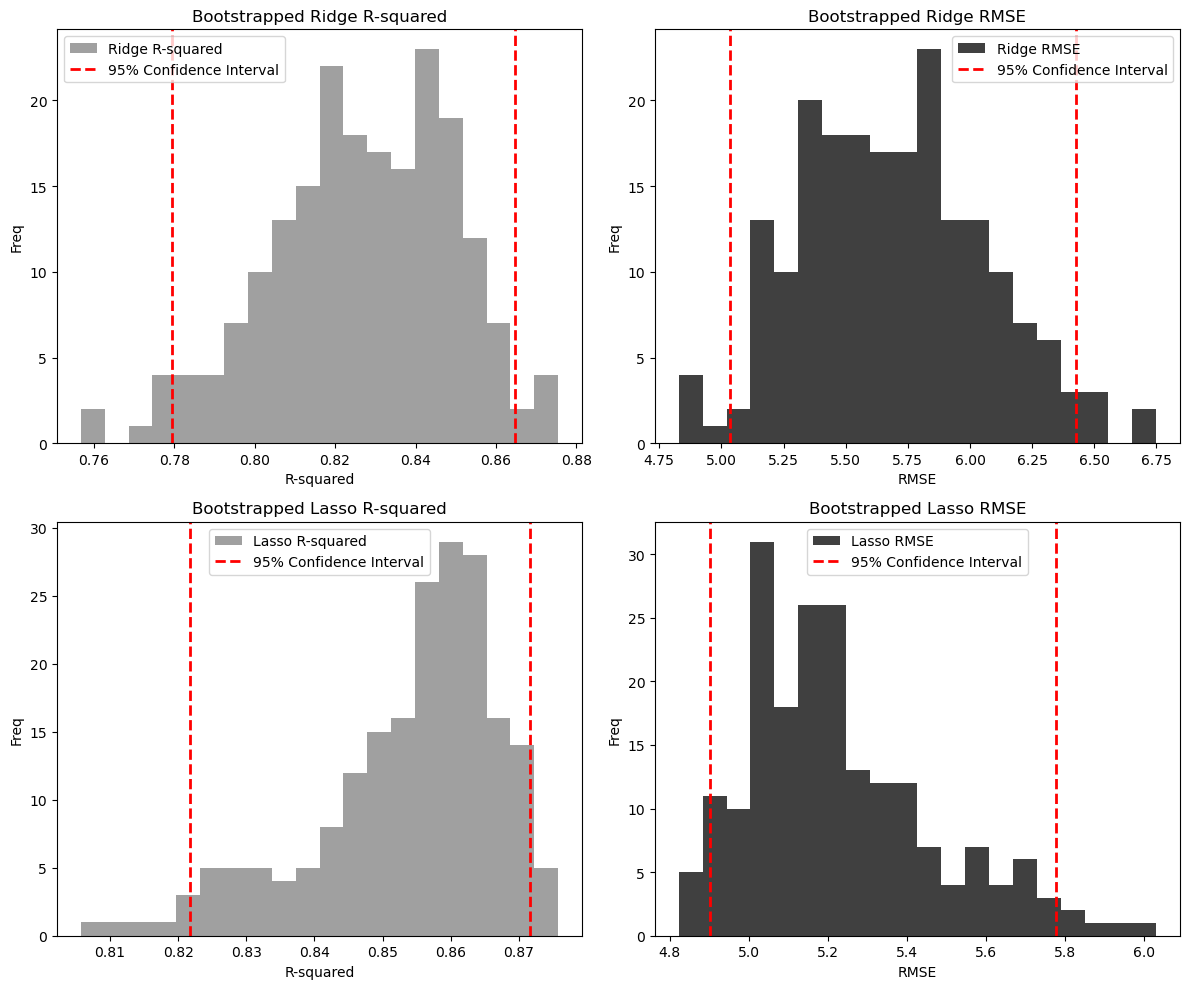

In [8]:
X = mean_aqi[['State Code', 'Pollutant']]
y = mean_aqi['AQI']

encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

n_bootstraps = 200
ridge_r2_scores = []
ridge_rmse_scores = []
lasso_r2_scores = []
lasso_rmse_scores = []

for _ in range(n_bootstraps):
    indices = np.random.choice(range(X_train.shape[0]), X_train.shape[0], replace=True)
    X_train_bootstrap = X_train[indices]
    y_train_bootstrap = y_train.iloc[indices]

    ridge = Ridge(alpha=ridge_cv.alpha_)
    ridge.fit(X_train_bootstrap, y_train_bootstrap)
    
    lasso = Lasso(alpha=lasso_cv.alpha_)
    lasso.fit(X_train_bootstrap, y_train_bootstrap)
    
    ridge_pred = ridge.predict(X_test)
    lasso_pred = lasso.predict(X_test)

    ridge_r2_scores.append(r2_score(y_test, ridge_pred))
    ridge_rmse_scores.append(np.sqrt(mean_squared_error(y_test, ridge_pred)))
    lasso_r2_scores.append(r2_score(y_test, lasso_pred))
    lasso_rmse_scores.append(np.sqrt(mean_squared_error(y_test, lasso_pred)))

ridge_r2_ci = np.percentile(ridge_r2_scores, [2.5, 97.5])
ridge_rmse_ci = np.percentile(ridge_rmse_scores, [2.5, 97.5])
lasso_r2_ci = np.percentile(lasso_r2_scores, [2.5, 97.5])
lasso_rmse_ci = np.percentile(lasso_rmse_scores, [2.5, 97.5])

print("Ridge Regression:")
print("Bootstrapped R-squared 95% CI:", ridge_r2_ci)
print("Bootstrapped RMSE 95% CI:", ridge_rmse_ci)
print("\nLasso Regression:")
print("Bootstrapped R-squared 95% CI:", lasso_r2_ci)
print("Bootstrapped RMSE 95% CI:", lasso_rmse_ci)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].hist(ridge_r2_scores, bins=20, alpha=0.75, color='gray', label='Ridge R-squared')
ax[0, 0].axvline(ridge_r2_ci[0], color='red', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax[0, 0].axvline(ridge_r2_ci[1], color='red', linestyle='dashed', linewidth=2)
ax[0, 0].set_xlabel('R-squared')
ax[0, 0].set_ylabel('Freq')
ax[0, 0].set_title('Bootstrapped Ridge R-squared')
ax[0, 0].legend()

ax[0, 1].hist(ridge_rmse_scores, bins=20, alpha=0.75, color='black', label='Ridge RMSE')
ax[0, 1].axvline(ridge_rmse_ci[0], color='red', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax[0, 1].axvline(ridge_rmse_ci[1], color='red', linestyle='dashed', linewidth=2)
ax[0, 1].set_xlabel('RMSE')
ax[0, 1].set_ylabel('Freq')
ax[0, 1].set_title('Bootstrapped Ridge RMSE')
ax[0, 1].legend()

ax[1, 0].hist(lasso_r2_scores, bins=20, alpha=0.75, color='gray', label='Lasso R-squared')
ax[1, 0].axvline(lasso_r2_ci[0], color='red', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax[1, 0].axvline(lasso_r2_ci[1], color='red', linestyle='dashed', linewidth=2)
ax[1, 0].set_xlabel('R-squared')
ax[1, 0].set_ylabel('Freq')
ax[1, 0].set_title('Bootstrapped Lasso R-squared')
ax[1, 0].legend()

ax[1, 1].hist(lasso_rmse_scores, bins=20, alpha=0.75, color='black', label='Lasso RMSE')
ax[1, 1].axvline(lasso_rmse_ci[0], color='red', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax[1, 1].axvline(lasso_rmse_ci[1], color='red', linestyle='dashed', linewidth=2)
ax[1, 1].set_xlabel('RMSE')
ax[1, 1].set_ylabel('Freq')
ax[1, 1].set_title('Bootstrapped Lasso RMSE')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

What we can get from the above 4 graphs are these:
1. R_squared of Ridge Regression: centers around 0.81, moderately improved compared to the simple linear model, with a better distribution since it focuses more around the center, but still wide ranged covering from 0.77 to 0.86.
2. RMSE of Ridge Regression: centers around 5.7, moderately improved compared to the simple linear model, with a similar distribution that almost evenly distribute, indicating a instability.
3. R_squared of Lasso Regression: centers at 0.86, much better than both previous models, and distribution is more centered at the higher values than lower ones, the range also covers higher range, from 0.82 to 0.88, this is significant improvement.
4. RMSE of Lasso Regression: centers around 5.1, with a centered distribution at 5 to 5.3, which means not only the RMSE are lower, but the overall range is lower, and the distribution is more promising.

As we can see, Ridge Regression does worse than Lasso Regression since it ranges greater in terms of RMSE and less in terms of R_squared. As a comparison, they still both outperforms the simple linear regression model from before, which means regularization methods works for this dataset and improves our ability to predict and understand the relationship of state and pollutants. The overall distribution for Lasso Regression Model is more reliable since the R_squared is more centered at around 0.865, with the RMSE relatively stable centering at about 5, which is a huge improvement compared to the distribution of Ridge and Simple Linear Regression.

But can we improve further than this?

# Non-Linear Model Techniques with Bootstrap

Now I plan to run the same bootstrap method to test the non-linear model performance against all previous models, which in this case is a random forrest. 

Bootstrapped R-squared 95% CI: (0.820, 0.874)
Bootstrapped RMSE 95% CI: (4.850, 5.813)


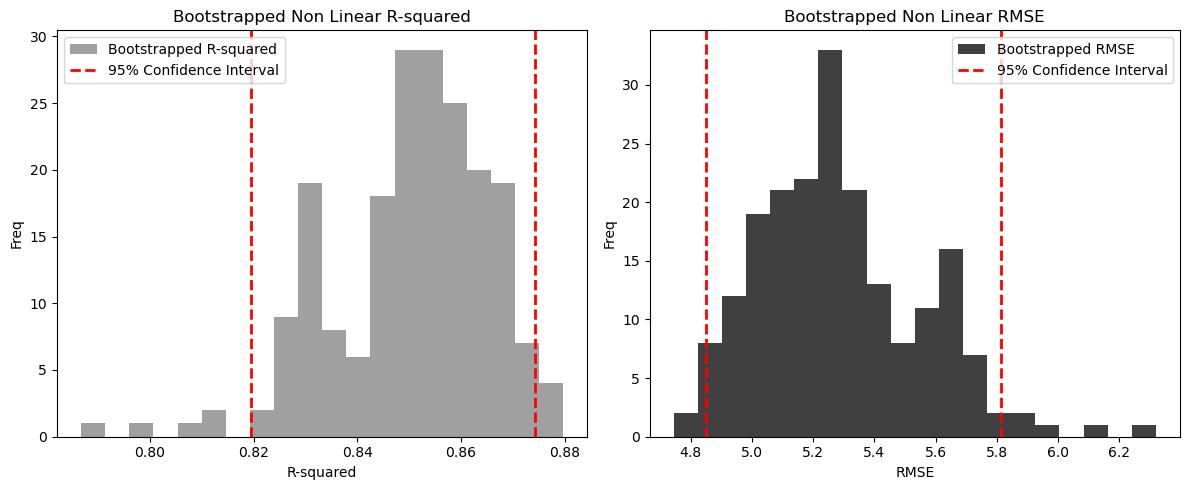

In [9]:
X = mean_aqi[['State Code', 'Pollutant']]
y = mean_aqi['AQI']

encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

n_bootstraps = 200

bootstrap_r2 = []
bootstrap_rmse = []
for _ in range(n_bootstraps):
    indices = np.random.choice(range(X_train.shape[0]), X_train.shape[0], replace=True)
    X_train_bootstrap = X_train[indices]
    y_train_bootstrap = y_train.iloc[indices]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_bootstrap, y_train_bootstrap)

    y_pred = rf_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    bootstrap_r2.append(r2)
    bootstrap_rmse.append(rmse)

r2_ci_lower = np.percentile(bootstrap_r2, 2.5)
r2_ci_upper = np.percentile(bootstrap_r2, 97.5)
rmse_ci_lower = np.percentile(bootstrap_rmse, 2.5)
rmse_ci_upper = np.percentile(bootstrap_rmse, 97.5)

print("Bootstrapped R-squared 95% CI: ({:.3f}, {:.3f})".format(r2_ci_lower, r2_ci_upper))
print("Bootstrapped RMSE 95% CI: ({:.3f}, {:.3f})".format(rmse_ci_lower, rmse_ci_upper))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(bootstrap_r2, bins=20, alpha=0.75, color='gray', label='Bootstrapped R-squared')
ax[0].axvline(r2_ci_lower, color='red', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax[0].axvline(r2_ci_upper, color='red', linestyle='dashed', linewidth=2)
ax[0].set_xlabel('R-squared')
ax[0].set_ylabel('Freq')
ax[0].set_title('Bootstrapped Non Linear R-squared')
ax[0].legend()

ax[1].hist(bootstrap_rmse, bins=20, alpha=0.75, color='black', label='Bootstrapped RMSE')
ax[1].axvline(rmse_ci_lower, color='red', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax[1].axvline(rmse_ci_upper, color='red', linestyle='dashed', linewidth=2)
ax[1].set_xlabel('RMSE')
ax[1].set_ylabel('Freq')
ax[1].set_title('Bootstrapped Non Linear RMSE')
ax[1].legend()

plt.tight_layout()
plt.show()

As we can see, the non-linear R_squared is even better than most of our previous models! This is probably due to how certain states has certain types of factories or labs that emmits the specific type of pollutants. The RMSE is also lower in this model, and the confidence interval for both R_squared and RMSE are more reliable than a linear model. However, we can see that the distrbution of R_squared and RMSE are not as desirable as the Lasso Regression, since Random Forrest model's r2 and rmse are more scattered but with similar expected value as those from Lasso, so preferably we would choose Lasso for pollution AQI predictions. 

# Conclusion:
currently we have found that in terms of this specific dataset, Lasso Regression model and Random Forrest performs the best with about the almost the same performance in terms of high R squared and low RMSE. This means now with these two models we can confidently predict the AQI for different pollutants and states in the United States. Both Lasso Regression and Random Forest models provide us with valuable insights into the relationships between the input features and AQI levels. By leveraging these models, we can identify the most significant factors contributing to air pollution levels and inform policymakers to focus on these areas for more effective interventions. The Lasso Regression model, in particular, is helpful in feature selection as it tends to set the coefficients of less important features to zero. This can lead to a more interpretable model and help us better understand the underlying mechanisms of air pollution. On the other hand, the Random Forest model can capture more complex interactions between features and is more resilient to overfitting due to its ensemble nature.

Overall, both Lasso Regression and Random Forest models offer promising results for predicting AQI levels in the United States. By using these models, we can make data-driven decisions to improve air quality and work towards a healthier environment for everyone.